### 모델 테스트용 코드

- 모델 테스트 및 성능 평가

In [13]:
### Colab 사용시 주석 제거

# !rm -rf SKN19_2ND_5TEAM
# !git clone https://github.com/SKNetworks-AI19-250818/SKN19_2ND_5TEAM.git
# %cd SKN19_2ND_5TEAM

# import sys
# sys.path.append('/content/SKN19_2ND_5TEAM')

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch

import modules.DataAnalysis as DataAnalysis
import modules.ModelAnalysis as ModelAnalysis
import modules.DataModify as DataModify
from modules.DataModify import DataPreprocessing

import modules.Models as Models

In [15]:
input_file_path = ['./data/encoded_dataset.csv']

# 랜덤 시드 고정 : 결과 비교용
Models.set_seed(42)

# device 설정 (cuda 사용 가능 시 cuda 사용)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Dataset 로드
dataset = DataModify.CancerDataset(
    target_column='target_label',              # target column
    time_column='Survival months_bin_3m',      # Survival months
    file_paths=input_file_path,
    transform=None          # 기존에 정제가 완료된 데이터를 사용할 경우 None
)

Using device: cpu


In [16]:
import torch

input_dim = dataset.data.shape[1]   # input dimension : data의 feature의 개수
hidden_size = (128, 64)             # 1번째, 2번째 hidden layer의 size
time_bins = 100                     # 3개월 단위로 time을 split하여 각 구간으로 삼음 -> 최대 300개월
num_events = 4                      # 사건의 개수

# 모델 정의 (학습할 때 사용한 모델 클래스)
model = Models.DeepHitSurvWithSEBlock(input_dim, 
                    hidden_size, 
                    time_bins, 
                    num_events)  # 사건 수 맞게 설정
model.load_state_dict(torch.load('./data/deephit_model.pth', map_location=device))
model.to(device)
model.eval()  # 평가 모드

from torch.utils.data import DataLoader, Subset

test_subset = Subset(dataset, indices=list(range(5, 10)))
test_loader = DataLoader(test_subset, batch_size=5, shuffle=False)

with torch.no_grad():  # 평가 시에는 gradient 계산 필요 없음
    for x, times, events in test_loader: 
        x, times, events = x.to(device), times.to(device), events.to(device)

        # 예측
        _, pmf, cif = model(x)  # DeepHit 모델이 pmf, cif 반환한다고 가정
        print("PMF shape:", pmf.shape)
        print("CIF shape:", cif.shape)
        print("CIF:", cif)  # 각 사건의 누적 확률


PMF shape: torch.Size([5, 4, 100])
CIF shape: torch.Size([5, 4, 100])
CIF: tensor([[[7.6147e-04, 2.9328e-03, 6.8754e-03,  ..., 9.8519e-01,
          9.9490e-01, 1.0000e+00],
         [6.5911e-04, 1.1932e-03, 1.7421e-03,  ..., 7.7803e-01,
          8.7192e-01, 1.0000e+00],
         [1.9637e-04, 4.1391e-04, 7.7772e-04,  ..., 8.4096e-01,
          9.2173e-01, 1.0000e+00],
         [1.8143e-19, 3.8900e-19, 5.7164e-19,  ..., 1.0000e+00,
          1.0000e+00, 1.0000e+00]],

        [[3.0798e-07, 3.6445e-07, 1.4499e-06,  ..., 9.4955e-01,
          9.7311e-01, 1.0000e+00],
         [9.7196e-10, 9.8465e-10, 9.8801e-10,  ..., 7.9255e-01,
          8.9859e-01, 1.0000e+00],
         [2.4119e-12, 2.9409e-12, 5.7321e-12,  ..., 8.9542e-01,
          9.4015e-01, 1.0000e+00],
         [1.3636e-24, 4.8062e-24, 9.3741e-24,  ..., 1.0000e+00,
          1.0000e+00, 1.0000e+00]],

        [[1.5488e-04, 2.2825e-04, 4.1227e-04,  ..., 9.5367e-01,
          9.7322e-01, 1.0000e+00],
         [2.0920e-06, 2.3751e-

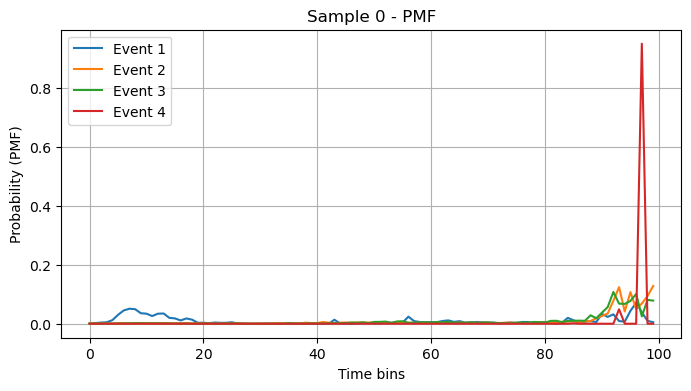

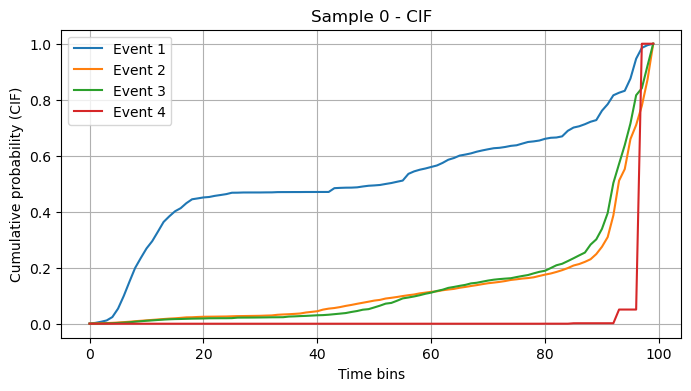

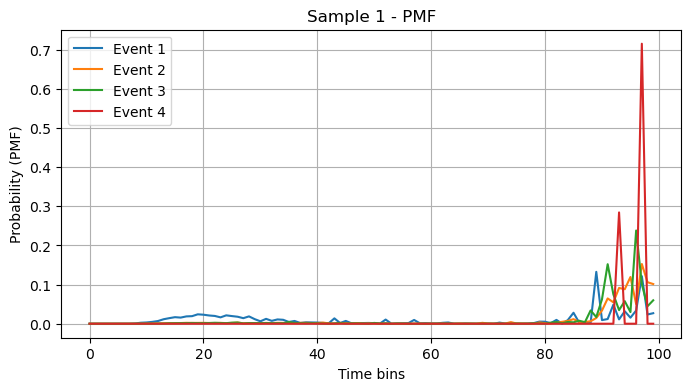

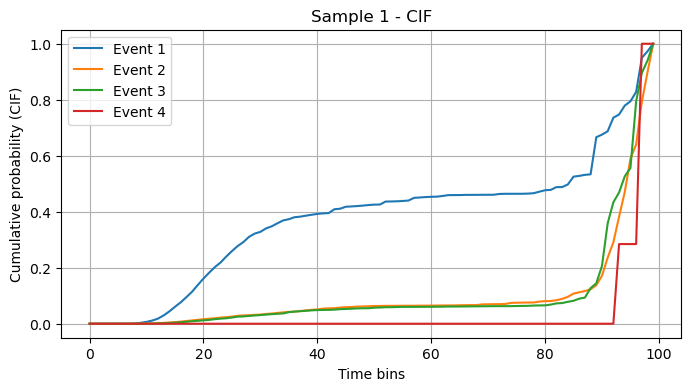

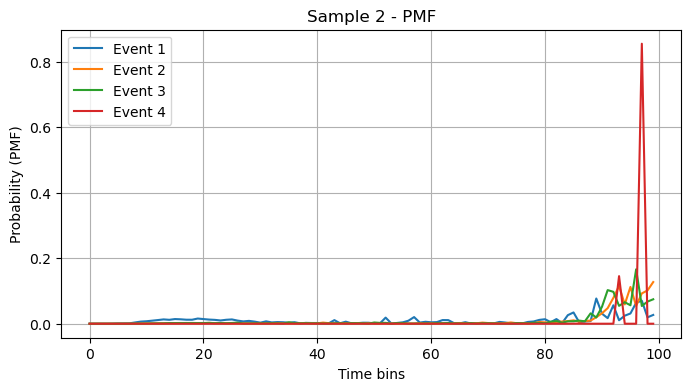

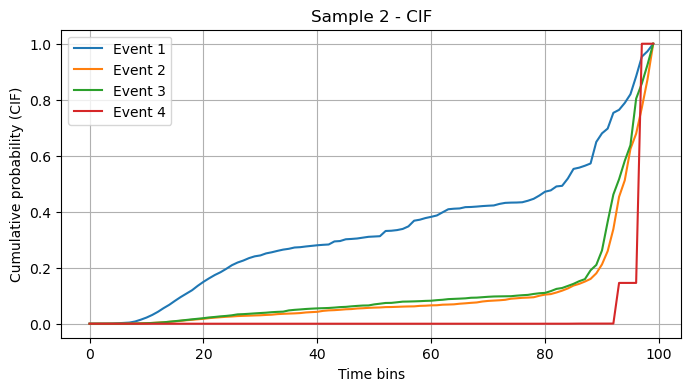

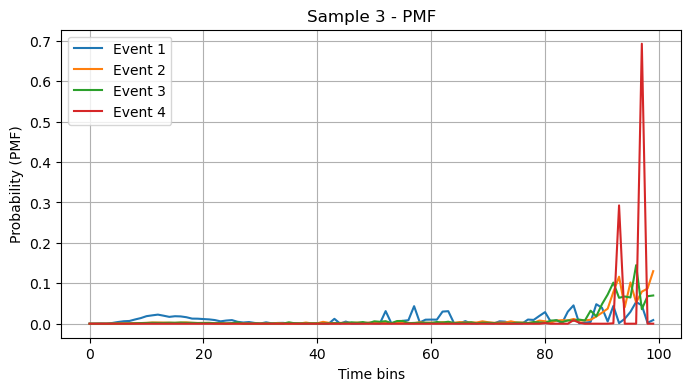

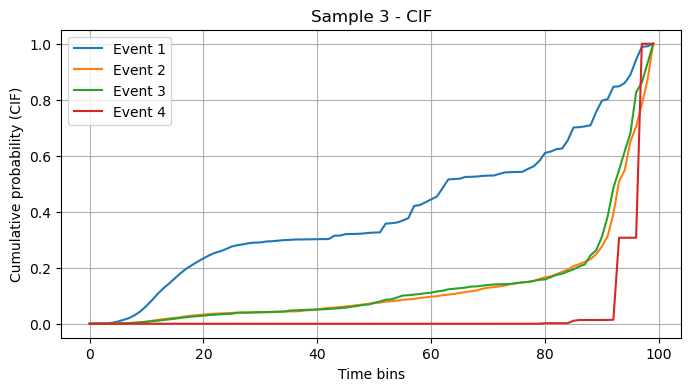

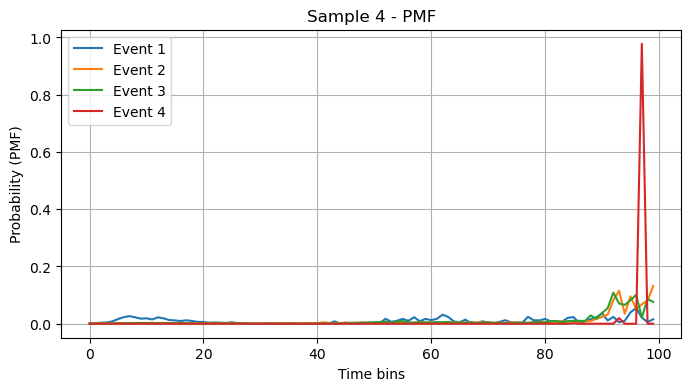

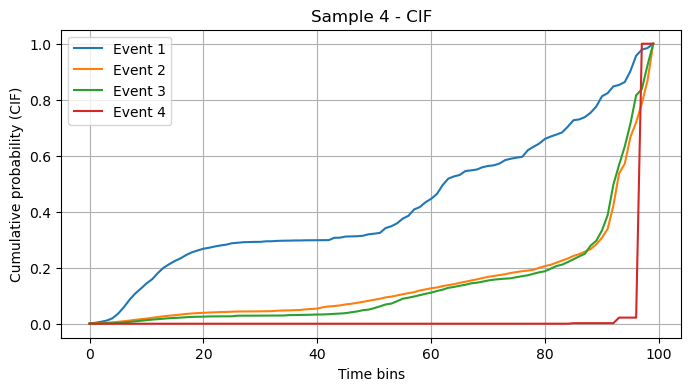

In [17]:
import matplotlib.pyplot as plt

with torch.no_grad():
    for x, times, events in test_loader: 
        x, times, events = x.to(device), times.to(device), events.to(device)

        _, pmf, cif = model(x)  # pmf, cif: (batch_size, num_events, time_bins)
        batch_size, num_events, time_bins = cif.shape
        time_points = list(range(time_bins))  # 시간축, 실제 bin 단위에 맞게 수정 가능

        for i in range(batch_size):
            # ===== PMF =====
            plt.figure(figsize=(8,4))
            for k in range(num_events):
                plt.plot(time_points, pmf[i, k].cpu().numpy().flatten(), label=f'Event {k+1}')
            plt.xlabel('Time bins')
            plt.ylabel('Probability (PMF)')
            plt.title(f'Sample {i} - PMF')
            plt.legend()
            plt.grid(True)
            plt.show()

            # ===== CIF =====
            plt.figure(figsize=(8,4))
            for k in range(num_events):
                plt.plot(time_points, cif[i, k].cpu().numpy().flatten(), label=f'Event {k+1}')
            plt.xlabel('Time bins')
            plt.ylabel('Cumulative probability (CIF)')
            plt.title(f'Sample {i} - CIF')
            plt.legend()
            plt.grid(True)
            plt.show()